# Rings Profile
This notebook contains code to analyze the rings data, in order to check if the data is in order and its distributions.

In [1]:
from boosted_lorenzetti.dataset import LztDataset
from boosted_lorenzetti.constants import N_RINGS
from boosted_lorenzetti.utils import set_logger
import boosted_lorenzetti.plotting.pyplot as lplt
import mplhep
import matplotlib.pyplot as plt
import matplotlib as mpl
from pathlib import Path
import ROOT
import numpy as np
import pandas as pd
import logging
from tqdm import tqdm

In [2]:
ROOT.EnableImplicitMT()
plt.style.use(mplhep.style.ATLAS)
set_logger()
mpl.rc('text', usetex = True)

# Load data

In [3]:
lzt_data = Path.home() / 'data' / 'lorenzetti'
output_dir = lzt_data / 'profiles' / 'boosted-lorenzetti-2025-04-18'
output_dir.mkdir(exist_ok=True, parents=True)
datasets = {}
datasets['zee'] = {
    'ds': LztDataset.from_dir(
        lzt_data / 'v2.2.0' / 'user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k'
    ),
    'color': 'blue',
    'label': '$Z \\to ee$',
}

datasets['zee_w_pileup'] = {
    'ds': LztDataset.from_dir(
        lzt_data / 'v2.2.0' / 'user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k.avgmu250_sigmamu50'
    ),
    'color': 'red',
    'label': '$Z \\to ee + <\\mu>=250$',
}

datasets

{'zee': {'ds': LztDataset(path=/root/data/lorenzetti/v2.2.0/user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k, label=Z->ee),
  'color': 'blue',
  'label': '$Z \\to ee$'},
 'zee_w_pileup': {'ds': LztDataset(path=/root/data/lorenzetti/v2.2.0/user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k.avgmu250_sigmamu50, label=Z->ee),
  'color': 'red',
  'label': '$Z \\to ee + <\\mu>=250$'}}

In [4]:
def load_data_from_aod(dataset: LztDataset, n_entries: int = -1) -> pd.DataFrame:
    rings_info = []
    iterator = tqdm(enumerate(dataset.aod_tchain),
                    desc='Processing events', unit=' events')
    if n_entries < 0:
        n_entries = np.inf
    for entry, aod_event in iterator:
        if entry >= n_entries:
            break
        event_number = aod_event.EventInfoContainer_Events[0].eventNumber
        for iring, rings_data in enumerate(aod_event.CaloRingsContainer_Rings):
            if rings_data.cluster_link >= len(aod_event.CaloClusterContainer_Clusters):
                logging.warning(f'{entry} - Event {event_number} - '
                                f'iring {iring} - Cluster link {rings_data.cluster_link} out of range')
                continue
            cluster_data = aod_event.CaloClusterContainer_Clusters[rings_data.cluster_link]
            record = {
                'event_number': event_number,
                'rings_size': len(rings_data.rings),
                'cl_eta': cluster_data.eta,
                'cl_phi': cluster_data.phi,
            }
            for i, ring in enumerate(rings_data.rings):
                record[f'ring_{i}'] = ring
            rings_info.append(record)
    rings_info = pd.DataFrame.from_dict(rings_info)
    return rings_info

In [5]:
def load_data_from_ntuple(dataset: LztDataset, n_entries: int = -1) -> pd.DataFrame:
    rings_info = []
    iterator = tqdm(enumerate(dataset.ntuple_tchain))
    if n_entries < 0:
        n_entries = np.inf
    for entry, event in iterator:
        if entry >= n_entries:
            break
        record = {
            'event_number': event.EventNumber,
            'rings_size': len(event.cl_rings),
            'cl_eta': event.cl_eta,
            'cl_phi': event.cl_phi,
        }
        for i, ring in enumerate(event.cl_rings):
            record[f'ring_{i}'] = ring
        rings_info.append(record)
    rings_info = pd.DataFrame.from_dict(rings_info)
    return rings_info

In [6]:
data_src = 'aod'
rewrite_cache = False
n_entries = -1
for name, dataset_info in datasets.items():
    output_filepath = output_dir / f'rings_info_{name}_{data_src}.parquet.gzip'
    if not rewrite_cache and output_filepath.exists():
        logging.info(f'Loading cached file for {name}')
        rings_info = pd.read_parquet(output_filepath)
    else:
        logging.info(f'Loading {name}')
        if data_src =='aod':
            rings_info = load_data_from_aod(dataset_info['ds'], n_entries)
        elif data_src == 'ntuple':
            rings_info = load_data_from_ntuple(dataset_info['ds'], n_entries)
        else:
            raise ValueError(f"Unknown data source: {data_src}")
        logging.info('Writing rings_info to parquet')
        rings_info.to_parquet(output_filepath,
                              compression='gzip')
    datasets[name]['rings_info'] = rings_info

2025-07-27 21:03:59 | INFO | root | 3318279325 | 10 | Loading zee


Processing events: 13068 events [02:30, 104.14 events/s]

2025-07-27 21:06:30 | WARNING | root | 758006356 | 13 | 13076 - Event 27299.0 - iring 0 - Cluster link 1 out of range


Processing events: 19838 events [03:47, 75.48 events/s] 

2025-07-27 21:07:47 | WARNING | root | 758006356 | 13 | 19842 - Event 88526.0 - iring 0 - Cluster link 1 out of range


Processing events: 56451 events [10:48, 62.75 events/s] 

2025-07-27 21:14:48 | WARNING | root | 758006356 | 13 | 56459 - Event 22157.0 - iring 0 - Cluster link 1 out of range


Processing events: 74900 events [14:32, 85.81 events/s] 


2025-07-27 21:18:34 | INFO | root | 3318279325 | 17 | Writing rings_info to parquet
2025-07-27 21:18:41 | INFO | root | 3318279325 | 10 | Loading zee_w_pileup


Processing events: 3119 events [00:38, 95.19 events/s] 

2025-07-27 21:19:20 | WARNING | root | 758006356 | 13 | 3119 - Event 58828.0 - iring 0 - Cluster link 1 out of range


Processing events: 3851 events [00:47, 84.54 events/s]

2025-07-27 21:19:29 | WARNING | root | 758006356 | 13 | 3857 - Event 13994.0 - iring 0 - Cluster link 1 out of range


Processing events: 4091 events [00:50, 81.12 events/s]

2025-07-27 21:19:32 | WARNING | root | 758006356 | 13 | 4097 - Event 63466.0 - iring 0 - Cluster link 1 out of range


Processing events: 6534 events [01:20, 70.68 events/s] 

2025-07-27 21:20:02 | WARNING | root | 758006356 | 13 | 6540 - Event 32134.0 - iring 0 - Cluster link 1 out of range


Processing events: 6929 events [01:25, 83.59 events/s] 

2025-07-27 21:20:06 | WARNING | root | 758006356 | 13 | 6935 - Event 85728.0 - iring 0 - Cluster link 1 out of range


Processing events: 7081 events [01:27, 75.37 events/s]

2025-07-27 21:20:09 | WARNING | root | 758006356 | 13 | 7087 - Event 6516.0 - iring 0 - Cluster link 1 out of range


Processing events: 8174 events [01:40, 84.01 events/s] 

2025-07-27 21:20:22 | WARNING | root | 758006356 | 13 | 8180 - Event 59809.0 - iring 0 - Cluster link 1 out of range


Processing events: 9824 events [02:01, 73.68 events/s] 

2025-07-27 21:20:42 | WARNING | root | 758006356 | 13 | 9824 - Event 55257.0 - iring 0 - Cluster link 1 out of range


Processing events: 10421 events [02:08, 84.01 events/s] 

2025-07-27 21:20:49 | WARNING | root | 758006356 | 13 | 10430 - Event 12593.0 - iring 0 - Cluster link 1 out of range


Processing events: 12343 events [02:31, 83.73 events/s] 

2025-07-27 21:21:12 | WARNING | root | 758006356 | 13 | 12348 - Event 14223.0 - iring 0 - Cluster link 1 out of range


Processing events: 13111 events [02:40, 82.37 events/s] 

2025-07-27 21:21:22 | WARNING | root | 758006356 | 13 | 13119 - Event 38613.0 - iring 0 - Cluster link 1 out of range


Processing events: 13817 events [02:48, 85.84 events/s] 

2025-07-27 21:21:30 | WARNING | root | 758006356 | 13 | 13823 - Event 53120.0 - iring 0 - Cluster link 1 out of range


Processing events: 15522 events [03:10, 72.76 events/s]

2025-07-27 21:21:51 | WARNING | root | 758006356 | 13 | 15525 - Event 74957.0 - iring 0 - Cluster link 1 out of range


Processing events: 15577 events [03:10, 76.34 events/s]

2025-07-27 21:21:52 | WARNING | root | 758006356 | 13 | 15587 - Event 74980.0 - iring 0 - Cluster link 1 out of range


Processing events: 15908 events [03:15, 68.10 events/s]

2025-07-27 21:21:56 | WARNING | root | 758006356 | 13 | 15913 - Event 76019.0 - iring 0 - Cluster link 1 out of range


Processing events: 18702 events [03:49, 77.10 events/s] 

2025-07-27 21:22:30 | WARNING | root | 758006356 | 13 | 18709 - Event 21490.0 - iring 0 - Cluster link 1 out of range


Processing events: 18969 events [03:52, 78.10 events/s]

2025-07-27 21:22:34 | WARNING | root | 758006356 | 13 | 18976 - Event 37993.0 - iring 0 - Cluster link 1 out of range


Processing events: 19160 events [03:55, 77.44 events/s]

2025-07-27 21:22:36 | WARNING | root | 758006356 | 13 | 19161 - Event 72882.0 - iring 0 - Cluster link 1 out of range


Processing events: 21775 events [04:27, 87.11 events/s] 

2025-07-27 21:23:08 | WARNING | root | 758006356 | 13 | 21782 - Event 54819.0 - iring 0 - Cluster link 1 out of range


Processing events: 22255 events [04:33, 81.32 events/s] 

2025-07-27 21:23:14 | WARNING | root | 758006356 | 13 | 22262 - Event 51041.0 - iring 0 - Cluster link 1 out of range


Processing events: 24225 events [04:57, 81.92 events/s] 

2025-07-27 21:23:39 | WARNING | root | 758006356 | 13 | 24226 - Event 79092.0 - iring 0 - Cluster link 1 out of range


Processing events: 24490 events [05:00, 107.68 events/s]

2025-07-27 21:23:42 | WARNING | root | 758006356 | 13 | 24497 - Event 97273.0 - iring 0 - Cluster link 1 out of range


Processing events: 25563 events [05:14, 86.90 events/s] 

2025-07-27 21:23:55 | WARNING | root | 758006356 | 13 | 25563 - Event 61504.0 - iring 0 - Cluster link 1 out of range


Processing events: 26277 events [05:22, 81.67 events/s]

2025-07-27 21:24:04 | WARNING | root | 758006356 | 13 | 26284 - Event 70253.0 - iring 0 - Cluster link 1 out of range


Processing events: 27595 events [05:38, 94.03 events/s] 

2025-07-27 21:24:20 | WARNING | root | 758006356 | 13 | 27601 - Event 79944.0 - iring 0 - Cluster link 1 out of range


Processing events: 28254 events [05:46, 95.15 events/s] 

2025-07-27 21:24:28 | WARNING | root | 758006356 | 13 | 28255 - Event 52481.0 - iring 0 - Cluster link 1 out of range


Processing events: 28401 events [05:48, 64.55 events/s] 

2025-07-27 21:24:30 | WARNING | root | 758006356 | 13 | 28410 - Event 78616.0 - iring 0 - Cluster link 1 out of range


Processing events: 33277 events [06:47, 94.33 events/s] 

2025-07-27 21:25:29 | WARNING | root | 758006356 | 13 | 33279 - Event 8353.0 - iring 0 - Cluster link 1 out of range


Processing events: 33296 events [06:47, 82.59 events/s]

2025-07-27 21:25:29 | WARNING | root | 758006356 | 13 | 33303 - Event 17884.0 - iring 0 - Cluster link 1 out of range


Processing events: 33614 events [06:52, 63.72 events/s] 

2025-07-27 21:25:33 | WARNING | root | 758006356 | 13 | 33627 - Event 48875.0 - iring 0 - Cluster link 1 out of range


Processing events: 37313 events [07:38, 64.26 events/s] 

2025-07-27 21:26:20 | WARNING | root | 758006356 | 13 | 37315 - Event 55033.0 - iring 0 - Cluster link 1 out of range


Processing events: 38699 events [07:57, 77.33 events/s]

2025-07-27 21:26:39 | WARNING | root | 758006356 | 13 | 38703 - Event 61036.0 - iring 0 - Cluster link 1 out of range


Processing events: 39782 events [08:11, 86.16 events/s] 

2025-07-27 21:26:52 | WARNING | root | 758006356 | 13 | 39786 - Event 46004.0 - iring 0 - Cluster link 1 out of range


Processing events: 39943 events [08:13, 67.69 events/s]

2025-07-27 21:26:55 | WARNING | root | 758006356 | 13 | 39948 - Event 78589.0 - iring 0 - Cluster link 1 out of range


Processing events: 40646 events [08:22, 87.21 events/s] 

2025-07-27 21:27:04 | WARNING | root | 758006356 | 13 | 40647 - Event 39647.0 - iring 0 - Cluster link 1 out of range


Processing events: 41664 events [08:35, 70.68 events/s]

2025-07-27 21:27:17 | WARNING | root | 758006356 | 13 | 41666 - Event 99963.0 - iring 0 - Cluster link 1 out of range


Processing events: 42535 events [08:46, 74.33 events/s] 

2025-07-27 21:27:28 | WARNING | root | 758006356 | 13 | 42535 - Event 24868.0 - iring 0 - Cluster link 1 out of range


Processing events: 42551 events [08:46, 69.01 events/s]

2025-07-27 21:27:28 | WARNING | root | 758006356 | 13 | 42559 - Event 24844.0 - iring 0 - Cluster link 1 out of range


Processing events: 42703 events [08:48, 82.77 events/s]

2025-07-27 21:27:30 | WARNING | root | 758006356 | 13 | 42707 - Event 75395.0 - iring 0 - Cluster link 1 out of range


Processing events: 43094 events [08:53, 90.05 events/s]

2025-07-27 21:27:35 | WARNING | root | 758006356 | 13 | 43102 - Event 56011.0 - iring 0 - Cluster link 1 out of range


Processing events: 43714 events [09:01, 68.26 events/s]

2025-07-27 21:27:42 | WARNING | root | 758006356 | 13 | 43722 - Event 24622.0 - iring 0 - Cluster link 1 out of range


Processing events: 44181 events [09:07, 82.27 events/s]

2025-07-27 21:27:48 | WARNING | root | 758006356 | 13 | 44184 - Event 45331.0 - iring 0 - Cluster link 1 out of range


Processing events: 44210 events [09:07, 73.64 events/s]

2025-07-27 21:27:49 | WARNING | root | 758006356 | 13 | 44214 - Event 71095.0 - iring 0 - Cluster link 1 out of range


Processing events: 45999 events [09:30, 108.10 events/s]

2025-07-27 21:28:11 | WARNING | root | 758006356 | 13 | 46000 - Event 41800.0 - iring 0 - Cluster link 1 out of range


Processing events: 46326 events [09:34, 73.32 events/s] 

2025-07-27 21:28:15 | WARNING | root | 758006356 | 13 | 46328 - Event 51891.0 - iring 0 - Cluster link 1 out of range


Processing events: 46722 events [09:39, 68.98 events/s]

2025-07-27 21:28:21 | WARNING | root | 758006356 | 13 | 46726 - Event 6705.0 - iring 0 - Cluster link 1 out of range


Processing events: 46861 events [09:41, 79.89 events/s]

2025-07-27 21:28:23 | WARNING | root | 758006356 | 13 | 46867 - Event 62321.0 - iring 0 - Cluster link 1 out of range


Processing events: 52134 events [10:44, 87.40 events/s] 

2025-07-27 21:29:25 | WARNING | root | 758006356 | 13 | 52140 - Event 25788.0 - iring 0 - Cluster link 1 out of range


Processing events: 53185 events [10:56, 83.14 events/s] 

2025-07-27 21:29:38 | WARNING | root | 758006356 | 13 | 53189 - Event 85067.0 - iring 0 - Cluster link 1 out of range


Processing events: 53327 events [10:58, 85.06 events/s]

2025-07-27 21:29:39 | WARNING | root | 758006356 | 13 | 53329 - Event 71786.0 - iring 0 - Cluster link 1 out of range


Processing events: 54341 events [11:10, 102.11 events/s]

2025-07-27 21:29:51 | WARNING | root | 758006356 | 13 | 54347 - Event 25592.0 - iring 0 - Cluster link 1 out of range


Processing events: 54453 events [11:11, 89.42 events/s] 

2025-07-27 21:29:52 | WARNING | root | 758006356 | 13 | 54453 - Event 71149.0 - iring 0 - Cluster link 1 out of range


Processing events: 54629 events [11:13, 72.87 events/s]

2025-07-27 21:29:55 | WARNING | root | 758006356 | 13 | 54632 - Event 50947.0 - iring 0 - Cluster link 1 out of range


Processing events: 55284 events [11:23, 73.20 events/s]

2025-07-27 21:30:04 | WARNING | root | 758006356 | 13 | 55291 - Event 16740.0 - iring 0 - Cluster link 1 out of range


Processing events: 55645 events [11:27, 73.56 events/s]

2025-07-27 21:30:09 | WARNING | root | 758006356 | 13 | 55650 - Event 40510.0 - iring 0 - Cluster link 1 out of range


Processing events: 59594 events [12:20, 77.80 events/s]

2025-07-27 21:31:01 | WARNING | root | 758006356 | 13 | 59595 - Event 52679.0 - iring 0 - Cluster link 1 out of range


Processing events: 61129 events [12:42, 71.23 events/s]

2025-07-27 21:31:23 | WARNING | root | 758006356 | 13 | 61136 - Event 57466.0 - iring 0 - Cluster link 1 out of range


Processing events: 62189 events [12:56, 71.71 events/s]

2025-07-27 21:31:38 | WARNING | root | 758006356 | 13 | 62193 - Event 2832.0 - iring 0 - Cluster link 1 out of range


Processing events: 65132 events [13:39, 62.86 events/s]

2025-07-27 21:32:21 | WARNING | root | 758006356 | 13 | 65137 - Event 4528.0 - iring 0 - Cluster link 1 out of range


Processing events: 68689 events [14:25, 95.92 events/s] 

2025-07-27 21:33:06 | WARNING | root | 758006356 | 13 | 68693 - Event 43609.0 - iring 0 - Cluster link 1 out of range


Processing events: 69119 events [14:30, 88.86 events/s] 

2025-07-27 21:33:11 | WARNING | root | 758006356 | 13 | 69119 - Event 34471.0 - iring 0 - Cluster link 1 out of range


Processing events: 69422 events [14:33, 90.09 events/s] 

2025-07-27 21:33:15 | WARNING | root | 758006356 | 13 | 69426 - Event 13535.0 - iring 0 - Cluster link 1 out of range


Processing events: 69477 events [14:34, 94.80 events/s]

2025-07-27 21:33:15 | WARNING | root | 758006356 | 13 | 69479 - Event 13515.0 - iring 0 - Cluster link 1 out of range


Processing events: 71132 events [14:54, 74.93 events/s] 

2025-07-27 21:33:35 | WARNING | root | 758006356 | 13 | 71135 - Event 91768.0 - iring 0 - Cluster link 1 out of range


Processing events: 71485 events [14:58, 87.07 events/s]

2025-07-27 21:33:40 | WARNING | root | 758006356 | 13 | 71491 - Event 94566.0 - iring 0 - Cluster link 1 out of range


Processing events: 73801 events [15:26, 70.79 events/s] 

2025-07-27 21:34:07 | WARNING | root | 758006356 | 13 | 73805 - Event 58997.0 - iring 0 - Cluster link 1 out of range


Processing events: 76935 events [16:07, 79.70 events/s] 

2025-07-27 21:34:48 | WARNING | root | 758006356 | 13 | 76941 - Event 21098.0 - iring 0 - Cluster link 1 out of range


Processing events: 78661 events [16:29, 84.34 events/s]

2025-07-27 21:35:11 | WARNING | root | 758006356 | 13 | 78662 - Event 96807.0 - iring 0 - Cluster link 1 out of range


Processing events: 79834 events [16:45, 75.18 events/s]

2025-07-27 21:35:27 | WARNING | root | 758006356 | 13 | 79841 - Event 19358.0 - iring 0 - Cluster link 1 out of range


Processing events: 80629 events [16:55, 67.61 events/s] 

2025-07-27 21:35:36 | WARNING | root | 758006356 | 13 | 80634 - Event 26983.0 - iring 0 - Cluster link 1 out of range


Processing events: 81881 events [17:11, 65.24 events/s]

2025-07-27 21:35:52 | WARNING | root | 758006356 | 13 | 81888 - Event 42381.0 - iring 0 - Cluster link 1 out of range


Processing events: 82451 events [17:19, 80.53 events/s]

2025-07-27 21:36:00 | WARNING | root | 758006356 | 13 | 82451 - Event 70653.0 - iring 0 - Cluster link 1 out of range


Processing events: 82762 events [17:23, 81.32 events/s]

2025-07-27 21:36:04 | WARNING | root | 758006356 | 13 | 82771 - Event 56365.0 - iring 0 - Cluster link 1 out of range


Processing events: 82888 events [17:25, 80.16 events/s]

2025-07-27 21:36:06 | WARNING | root | 758006356 | 13 | 82888 - Event 30530.0 - iring 0 - Cluster link 1 out of range


Processing events: 83879 events [17:39, 72.59 events/s]

2025-07-27 21:36:20 | WARNING | root | 758006356 | 13 | 83880 - Event 67759.0 - iring 0 - Cluster link 1 out of range


Processing events: 83968 events [17:40, 68.92 events/s]

2025-07-27 21:36:21 | WARNING | root | 758006356 | 13 | 83969 - Event 37738.0 - iring 0 - Cluster link 1 out of range


Processing events: 84607 events [17:48, 74.59 events/s]

2025-07-27 21:36:30 | WARNING | root | 758006356 | 13 | 84613 - Event 93925.0 - iring 0 - Cluster link 1 out of range


Processing events: 84818 events [17:52, 55.41 events/s]

2025-07-27 21:36:33 | WARNING | root | 758006356 | 13 | 84827 - Event 93399.0 - iring 0 - Cluster link 1 out of range


Processing events: 85811 events [18:05, 65.69 events/s]

2025-07-27 21:36:46 | WARNING | root | 758006356 | 13 | 85818 - Event 17922.0 - iring 0 - Cluster link 1 out of range


Processing events: 86475 events [18:14, 67.36 events/s]

2025-07-27 21:36:55 | WARNING | root | 758006356 | 13 | 86475 - Event 22141.0 - iring 0 - Cluster link 1 out of range


Processing events: 87065 events [18:22, 72.10 events/s]

2025-07-27 21:37:03 | WARNING | root | 758006356 | 13 | 87068 - Event 97661.0 - iring 0 - Cluster link 1 out of range


Processing events: 88295 events [18:40, 61.46 events/s]

2025-07-27 21:37:21 | WARNING | root | 758006356 | 13 | 88300 - Event 82426.0 - iring 0 - Cluster link 1 out of range


Processing events: 89253 events [18:53, 73.61 events/s]

2025-07-27 21:37:35 | WARNING | root | 758006356 | 13 | 89258 - Event 11167.0 - iring 0 - Cluster link 1 out of range


Processing events: 90911 events [19:17, 65.33 events/s]

2025-07-27 21:37:58 | WARNING | root | 758006356 | 13 | 90912 - Event 90154.0 - iring 0 - Cluster link 1 out of range


Processing events: 93608 events [19:57, 62.21 events/s]

2025-07-27 21:38:39 | WARNING | root | 758006356 | 13 | 93613 - Event 79725.0 - iring 0 - Cluster link 1 out of range


Processing events: 93726 events [19:59, 71.94 events/s]

2025-07-27 21:38:40 | WARNING | root | 758006356 | 13 | 93734 - Event 74497.0 - iring 0 - Cluster link 1 out of range


Processing events: 95211 events [20:18, 72.58 events/s] 

2025-07-27 21:39:00 | WARNING | root | 758006356 | 13 | 95212 - Event 34652.0 - iring 0 - Cluster link 1 out of range


Processing events: 96348 events [20:31, 78.85 events/s] 

2025-07-27 21:39:13 | WARNING | root | 758006356 | 13 | 96348 - Event 30695.0 - iring 0 - Cluster link 1 out of range


Processing events: 96536 events [20:34, 74.78 events/s]

2025-07-27 21:39:15 | WARNING | root | 758006356 | 13 | 96538 - Event 14449.0 - iring 0 - Cluster link 1 out of range


Processing events: 96606 events [20:35, 76.56 events/s]

2025-07-27 21:39:16 | WARNING | root | 758006356 | 13 | 96611 - Event 82552.0 - iring 0 - Cluster link 1 out of range


Processing events: 97622 events [20:47, 84.48 events/s] 

2025-07-27 21:39:29 | WARNING | root | 758006356 | 13 | 97626 - Event 32201.0 - iring 0 - Cluster link 1 out of range


Processing events: 98355 events [20:56, 87.19 events/s] 

2025-07-27 21:39:38 | WARNING | root | 758006356 | 13 | 98360 - Event 60840.0 - iring 0 - Cluster link 1 out of range


Processing events: 98778 events [21:01, 89.07 events/s] 

2025-07-27 21:39:43 | WARNING | root | 758006356 | 13 | 98789 - Event 42079.0 - iring 0 - Cluster link 1 out of range


Processing events: 100000 events [21:17, 78.31 events/s]


2025-07-27 21:40:00 | INFO | root | 3318279325 | 17 | Writing rings_info to parquet


Warning in <TBranchElement::InitializeOffsets>: No streamer element for branch: CaloDetDescriptorContainer_Cells subbranch: CaloDetDescriptorContainer_Cells.sigma
Warning in <TBranchElement::InitializeOffsets>: No streamer element for branch: EventInfoContainer_Events subbranch: EventInfoContainer_Events.totmu
Error in <TChain::LoadTree>: Cannot find tree with name CollectionTree in file /root/data/lorenzetti/v2.2.0/user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k/AOD/67284a55963b.result.AOD.root
Error in <TChain::LoadTree>: Cannot find tree with name CollectionTree in file /root/data/lorenzetti/v2.2.0/user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k/AOD/68e22b41c25c.result.AOD.root
Error in <TChain::LoadTree>: Cannot find tree with name CollectionTree in file /root/data/lorenzetti/v2.2.0/user.joao.pinto.mc25_13TeV.250520.Pythia8EvtGen_Zee.100k/AOD/fd5a5f71567a.result.AOD.root
Error in <TChain::LoadTree>: Cannot find tree with name CollectionTree in file /root/data/lore

# Check number of vector entries

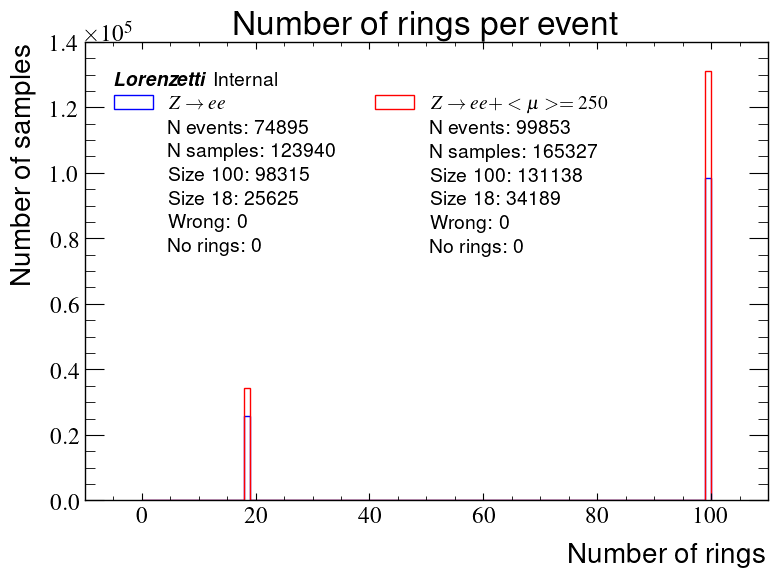

In [7]:
fig, ax = plt.subplots()
max_ring_size = -1
bins = np.arange(201)
for name, dataset_info in datasets.items():
    rings_info = dataset_info['rings_info']
    current_max_ring_size = rings_info['rings_size'].max()
    if current_max_ring_size > max_ring_size:
        max_ring_size = current_max_ring_size
    ax.hist(rings_info['rings_size'],
            bins=np.arange(current_max_ring_size + 1),
            histtype='step',
            color=dataset_info['color'],
            label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
    has_100 = rings_info["rings_size"] == 100
    ax.plot([], [], ' ',
            label=f'Size 100: {has_100.sum()}')
    has_18 = rings_info["rings_size"] == 18
    ax.plot([], [], ' ',
            label=f'Size 18: {has_18.sum()}')
    ax.plot([], [], ' ',
            label=f'Wrong: {((~has_100) & (~has_18)).sum()}')
    ax.plot([], [], ' ',
            label=f'No rings: {(rings_info["rings_size"] == 0).sum()}')
    # ax.plot([], [], ' ',
    #         label=f'Extra: {(rings_info["rings_size"] > N_RINGS).sum()}')
    # ax.plot([], [], ' ',
    #         label=f'Missing: {(rings_info["rings_size"] < N_RINGS).sum()}')
ax.set(
    xlabel='Number of rings',
    ylabel='Number of samples',
    title='Number of rings per event',
    xlim=(-10, max_ring_size + 10)
)
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          )
fig.tight_layout()
# fig.savefig(output_dir / f'number_of_rings_{data_src}.png', dpi=300)

/tmp/ipykernel_977424/3547811672.py:32: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  lower_ax.legend(alignment='left',


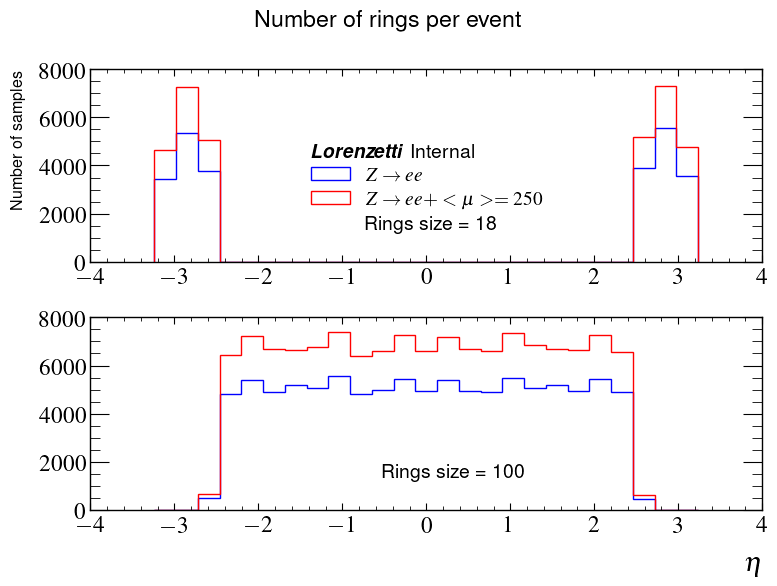

In [8]:
fig, axes = plt.subplots(2,1)
top_ax, lower_ax = axes
top_size = 18
lower_size = 100
for i, (name, dataset_info) in enumerate(datasets.items()):
    rings_info = dataset_info['rings_info']
    top_counts, top_bins, _ = top_ax.hist(
        rings_info.loc[rings_info['rings_size'] == top_size, 'cl_eta'],
        bins=25,
        histtype='step',
        color=dataset_info['color'],
        label=dataset_info['label'])
    # ax.grid(linestyle='--', alpha=0.5)
    if i == 1:
        top_ax.plot([], [], ' ',
                label=f'Rings size = {top_size}')
    top_ax.set_ylabel('Number of samples', fontsize='small')
    top_ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
                alignment='left',
                facecolor='white',
                ncols=1,
    )
    lower_ax.hist(
        rings_info.loc[rings_info['rings_size'] == lower_size, 'cl_eta'],
        bins=top_bins,
        histtype='step',
        color=dataset_info['color']
    )
    if i == 1:
        lower_ax.plot([], [], ' ',
                label=f'Rings size = {lower_size}')
    lower_ax.legend(alignment='left',
                facecolor='white',
                ncols=1,
    )
    lower_ax.set(
        xlabel='$\\eta$',
    )
fig.suptitle('Number of rings per event')
fig.tight_layout()
fig.savefig(output_dir / f'number_of_rings_multi_plot_{data_src}.png', dpi=300)

# Check $\mu \pm \sigma$

## Default

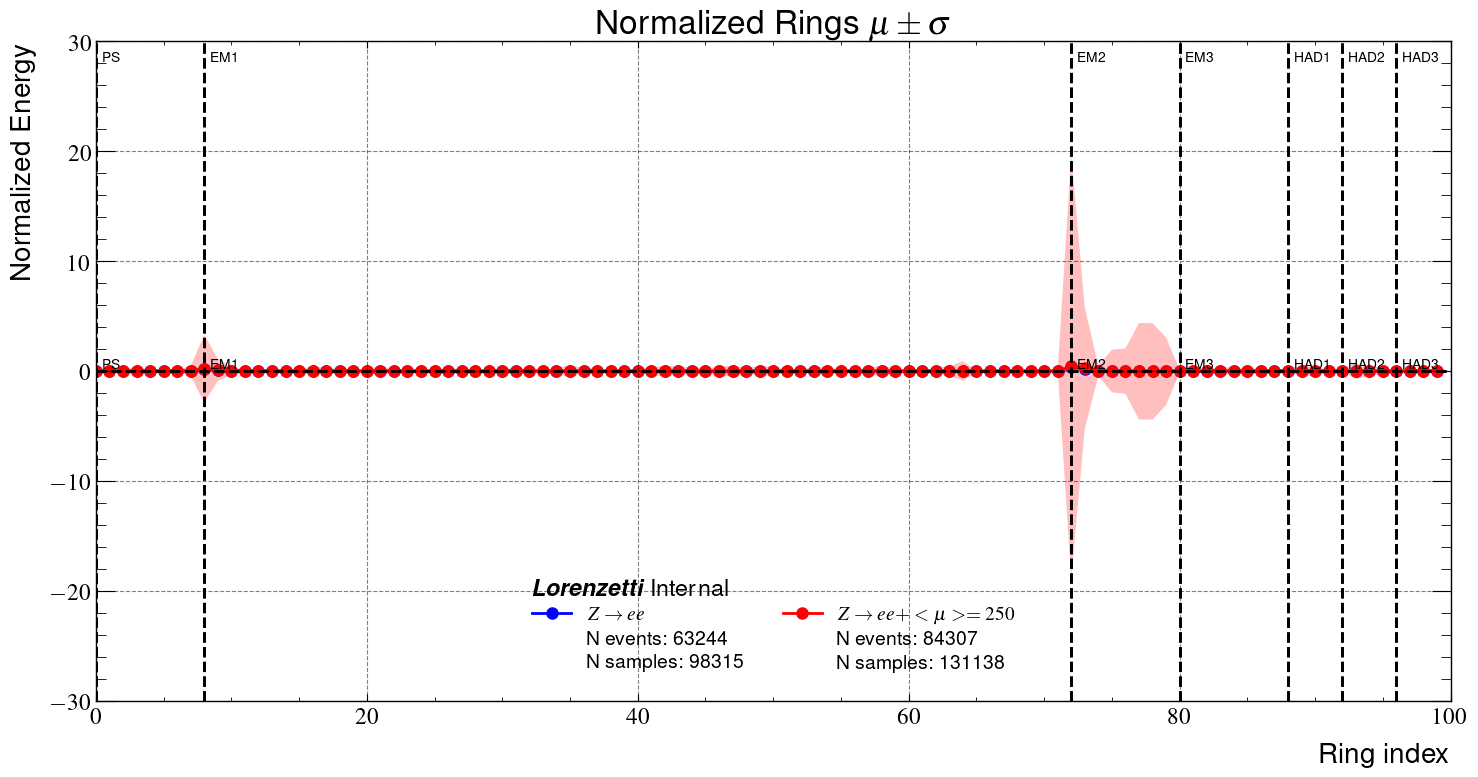

In [10]:
normalize=True
fig, ax = plt.subplots(figsize=(15, 8))
ax.grid(linestyle='--', alpha=0.5, color='k')
for name, dataset_info in datasets.items():
    rings_info = dataset_info['rings_info']
    rings_info = rings_info[rings_info['rings_size'] == N_RINGS]
    rings_columns = [f'ring_{i}' for i in range(rings_info.shape[-1]-4)]
    _ = lplt.plot_rings_profile(
        rings_info[rings_columns],
        ax=ax,
        normalize=normalize,
        color=dataset_info['color'],
        ax_set_kwargs=dict(
            ylabel='Normalized Energy' if normalize else 'Energy [MeV]',
        ),
        label=dataset_info['label']
    )
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          title_fontproperties=dict(size='large'),
          )
fig.tight_layout()
if normalize:
    figname = f'mean_rings_normalized_{data_src}.png'
else:
    figname = f'mean_rings_{data_src}.png'
fig.savefig(output_dir / figname, dpi=300)

# All Rings

In [ ]:
normalize=True
fig, ax = plt.subplots(figsize=(15, 8))
for i, (name, dataset_info) in enumerate(datasets.items()):
    logging.info(f'Plotting rings for {name}')
    x = np.arange(N_RINGS)
    rings_info = dataset_info['rings_info']
    rings_info = rings_info[rings_info['rings_size'] == N_RINGS]
    rings_columns = [f'ring_{i}' for i in range(rings_info.shape[-1]-2)]
    lplt.plot_all_rings(
        rings_info, ax,
        normalize=normalize,
        plot_kwargs=dict(
            color=dataset_info['color'],
            label=dataset_info['label'],
            alpha=0.01),
        add_rings_labels=(i==0))
    ax.plot([], [], ' ',
        label=f'N events: {rings_info["event_number"].nunique()}')
    ax.plot([], [], ' ',
            label=f'N samples: {len(rings_info)}')
    del rings_info
ax.legend(title='\\textbf{{\\textit{{Lorenzetti}}}} Internal',
          alignment='left',
          facecolor='white',
          ncols=len(datasets),
          title_fontproperties=dict(size='large'),
          )
fig.tight_layout()
if normalize:
    figname = f'all_rings_normalized_{data_src}_zee.png'
else:
    figname = f'all_rings_{data_src}.png'
# fig.savefig(output_dir / figname, dpi=300)